### Support Vector Machines (SVMs) Quadratic Programming

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time
import cvxopt

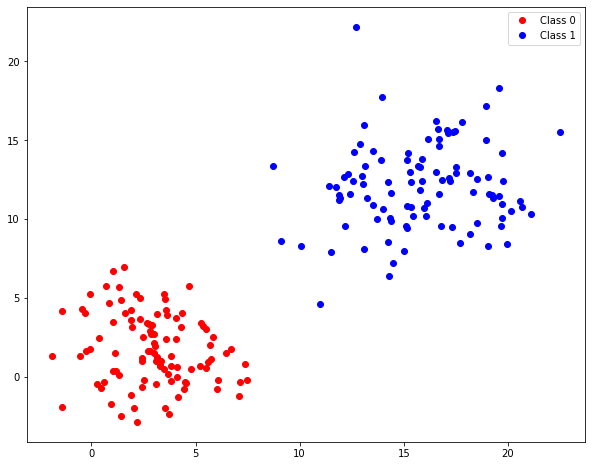

In [2]:
# Synthenic data
mu1 = np.array([3,2])
mu2 = np.array([16,12])
sigma = np.array([[6,0],[0,6]])

X1 = np.random.multivariate_normal(mu1,sigma,100)
X2 = np.random.multivariate_normal(mu2,sigma,100)

plt.figure(figsize=(10,8))
plt.plot(X1[:,0],X1[:,1],'ro',label='Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label='Class 1')
plt.legend()
plt.show()

**SVMs model**

- Training set: The data are pairs $(\mathbf{x}^{(i)},y^{(i)})$ with $\mathbf{x}^{(i)} \in \mathbb{R}^n$ and $y^{(i)} \in \{-1,1\}$.

$$
2D: \mathbf{X} = \begin{vmatrix}x_{1}^{1} & x_{2}^{1} \\x_{1}^{2} & x_{2}^{2}\\: & :\\x_{1}^{m} & x_{2}^{m}\end{vmatrix} , \mathbf{y} = \begin{vmatrix} -1\\-1\\:\\1\end{vmatrix}
$$

- Structure of model:

$$h_{\mathbf{w},b}(\mathbf{x}) = \begin{cases} 1 & \text{if} \; \mathbf{w}^\top \mathbf{x} + b > 0 \\ -1 & \text{otherwise} \end{cases}$$

- Cost function:
$$\mathbf{w}^*,b^* = \mathrm{argmax}_{\mathbf{w},b} \gamma,$$

    where $\gamma$ is the minimum geometric margin for the training data:
    $$\gamma = \min_i \gamma^{(i)}$$
    
    and $\gamma^{(i)}$ is the geometric margin for training example $i$, i.e., the signed distance of $\mathbf{x}^{(i)}$ from the decision boundary,
  with positive distances indicating that the point is on the correct side of the boundary and negative distances indicating that the point is on the
  incorrect side of the boundary:
  $$\gamma^{(i)} = y^{(i)}\left( \left( \frac{\mathbf{w}}{\|\mathbf{w}\|} \right)^\top \mathbf{x}^{(i)} + \frac{b}{\| \mathbf{w}\|} \right). $$

- Optimal solution (*General Quadratic Programming*):

$$x^{*} = arg \min_{x}\frac{1}{2}x^{T}Qx+c^{T}x+r $$ $$\text{Subject to : $Ax \leq b\\ Ex = d$}$$

- **cvxopt**.solvers.qp(P,q,G,h,A,b) find the **sol['x']**

- **n**: number of class, **m**: number of sample
$$
n = 2 :\mathbf{C} = \underbrace{\begin{vmatrix} 0\\0\\0\end{vmatrix}}_{(n+1)x1} ; \mathbf{Q} = \underbrace{\begin{vmatrix} 1&0&0\\0&1&0\\0&0&0\end{vmatrix}}_{(n+1)x(n+1)} ; \mathbf{A} = \underbrace{\begin{vmatrix} -x_{1}^{1}y^{1}&-x_{2}^{1}y^{1}&-y^{1}\\-x_{1}^{2}y^{2}&-x_{2}^{2}y^{2}&-y^{2}\\:&:&:\\-x_{1}^{m}y^{m}&-x_{2}^{m}y^{m}&-y^{m}\end{vmatrix}}_{mx3} ; \mathbf{X} = \underbrace{\begin{vmatrix} w_{1}\\w_{2}\\b\end{vmatrix}}_{(n+1)x1} ; \mathbf{b} = \underbrace{\begin{vmatrix} -1\\-1\\:\\-1\end{vmatrix}}_{mx1} 
$$

In [3]:
# Training set
X = np.concatenate((X1,X2))
y = np.concatenate((-np.ones((X1.shape[0],1)),np.ones((X1.shape[0],1))))

In [25]:
# SVMs model
def set_param(X,y):
    m = X.shape[0]
    n = len(np.unique(y))
    Q = np.eye(n+1)
    Q[n,n]=0
    c = np.zeros((n+1,1))
    A = - np.concatenate((X, np.ones((m,1))),1) * y
    b = - np.ones((m,1))
    return Q, c, A, b

def cvxopt_solvers_qp(Q,c,A=None,b=None,E=None,d=None):
    Q = .5*(Q+Q.T) # make Q is symmetric
    args = [cvxopt.matrix(Q),cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A),cvxopt.matrix(b)])
    if E is not None:
        args.extend([cvxopt.matrix(E),cvxopt.matrix(d)])
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(*args)
    return np.array(sol['x']).reshape(Q.shape[1])

def svms_fit(X,y):
    Q,c,A,b = set_param(X,y)
    opt_params = cvxopt_solvers_qp(Q,c,A,b)
    return opt_params 

def find_b_w(opt_params):
    w = opt_params[0:2]
    b = opt_params[2]
    print('Optimal Solution: b=',b,'w=',w)
    return b, w.reshape(1,-1)

def predict(X,b,w):
    preds = np.where(w@X.T+b >=0,+1,-1)
    return preds.reshape(-1,1)

def accuracy(X,y,b,w):
    preds = np.where(w@X.T+b >=0,+1,-1)
    acc = (preds.reshape(-1) == y.reshape(-1)).sum()/y.shape[0]
    return acc

In [26]:
#fit model
opt_params = svms_fit(X,y)

# find b, w
b, w = find_b_w(opt_params)

Optimal Solution: b= -3.7487874980580074 w= [0.35258483 0.19029943]


In [27]:
print('Training Accuracy:', accuracy(X,y,b,w))

Training Accuracy: 1.0


**SVMs decision boundary**:
- Center line: $W^{T}\mathbf{x}+b = 0$
- Margin : $W^{T}\mathbf{x}+b = 1$
- Margin : $W^{T}\mathbf{x}+b = -1$

**n = 2**:

- Center line : $w_{1}x_{1}+w_{2}x_{2} + b = 0 \rightarrow x_{2} = \frac{-w_{1}x_{1}-b}{w_{2}}$
- Margin: $w_{1}x_{1}+w_{2}x_{2} + b = 1 \rightarrow x_{2} = \frac{-w_{1}x_{1}-b+1}{w_{2}}$
- Margin : $w_{1}x_{1}+w_{2}x_{2} + b = -1 \rightarrow x_{2} = \frac{-w_{1}x_{1}-b-1}{w_{2}}$

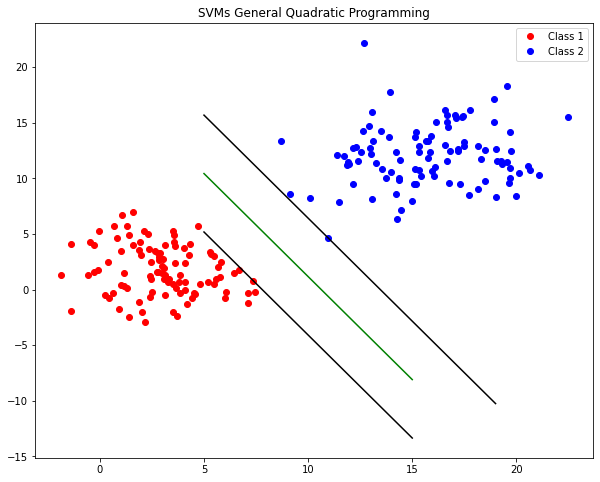

In [7]:
plt.figure(figsize=(10,8))
plt.plot(X[y.reshape(-1)==-1,0],X[y.reshape(-1)==-1,1],'ro',label='Class 1')
plt.plot(X[y.reshape(-1)==1,0],X[y.reshape(-1)==1,1],'bo',label='Class 2')

# Center line
x11 = 5
x12 = 15
x21 = (-w[0,0]*x11-b)/w[0,1]
x22 = (-w[0,0]*x12-b)/w[0,1]
plt.plot((x11,x12),(x21,x22),'g-')

# Red margin
x11 = 5
x12 = 15
x21 = (-w[0,0]*x11-b-1)/w[0,1]
x22 = (-w[0,0]*x12-b-1)/w[0,1]
plt.plot((x11,x12),(x21,x22),'k-')

# Blue margin
x11 = 5
x12 = 19
x21 = (-w[0,0]*x11-b+1)/w[0,1]
x22 = (-w[0,0]*x12-b+1)/w[0,1]
plt.plot((x11,x12),(x21,x22),'k-')
plt.title('SVMs General Quadratic Programming')
plt.legend()
plt.show()